# Breakout Group 4: Recognition: App

##Summary

We attempted the fulfil the rationale below. However, finding a visualisation form that was useful proved difficult in the time available. Communicating the complexity of what of precision, recall etc.

A Tableau packed bubble chart with bubbles below seemed to be the most promising potential avenue.

This would work with the confusion matrix categories below extracted from hipe-eval/HIPE-2022-eval

Although this is not implemented below.
https://help.tableau.com/current/pro/desktop/en-us/buildexamples_bubbles.htm

The recipe is not close to being useable at present.




## Rationale

When considering the adoption of large language models (LLMs) for annotating catalogue descriptions in Cultural Heritage collections, one of the most pressing concerns is reliability. Curators, archivists, and librarians must be assured that automated annotations will neither mislead users nor undermine the scholarly integrity of their catalogues. Quantitative evaluation metrics, while useful to specialists, are not always accessible or intuitive for wider professional audiences.

The visualisations presented here aim to bridge this gap by making system performance both transparent and comprehensible. By showing how the model’s accuracy varies across different categories of entities (such as persons, works, or thematic scopes), and under stricter or more lenient evaluation criteria, the charts provide an immediate sense of where the system performs strongly and where caution may be required. They also illustrate the balance between precision (avoiding false positives) and recall (capturing as many relevant items as possible), allowing stakeholders to see whether the system tends to over-generate or under-generate annotations. Finally, the heatmap offers a clear comparative overview, highlighting consistency and variability at a glance.

Together, these visualisations do not simply report raw numbers: they contextualise model behaviour in ways that build trust. They help demonstrate that annotation quality can be monitored, explained, and adjusted, thereby supporting informed decisions about the safe and responsible integration of LLMs into Cultural Heritage workflows.

##Recipe

In [ ]:
#@title Flatten input data

import requests
import pandas as pd

# Load JSON
url = "https://raw.githubusercontent.com/hipe-eval/HIPE-2022-eval/main/evaluation/system-evaluations/neurbsl_bundle3_ajmc_de_1_nerc_coarse.json"
data = requests.get(url).json()

# Flatten
records = []
for level, level_data in data.items():  # e.g. "NE-COARSE-LIT"
    for time, time_data in level_data.items():  # e.g. "TIME-ALL"
        for led, led_data in time_data.items():  # e.g. "LED-ALL"
            for ent, ent_data in led_data.items():  # e.g. "PERS", "SCOPE"
                for mode, metrics in ent_data.items():  # e.g. "partial", "strict"
                    row = {
                        "level": level,
                        "time": time,
                        "led": led,
                        "entity": ent,
                        "mode": mode,
                    }
                    row.update(metrics)
                    records.append(row)

df = pd.DataFrame(records)
df.head()


,level,time,led,entity,mode,correct,incorrect,partial,missed,spurious,...,P_macro_doc,R_macro_doc,F1_macro_doc,P_macro_doc_std,R_macro_doc_std,F1_macro_doc_std,P_macro,R_macro,F1_macro,F1_macro (recomputed from P & R)
0,NE-COARSE-LIT,TIME-ALL,LED-ALL,PERS,partial,122,0,4,2,7,...,0.899504,0.959432,0.924473,0.139868,0.065503,0.101725,NaN,NaN,NaN,NaN
1,NE-COARSE-LIT,TIME-ALL,LED-ALL,PERS,strict,118,8,0,2,7,...,0.836409,0.879802,0.854766,0.213386,0.166891,0.192547,NaN,NaN,NaN,NaN
2,NE-COARSE-LIT,TIME-ALL,LED-ALL,PERS,ent_type,122,4,0,2,7,...,0.882044,0.938210,0.905663,0.169082,0.130061,0.146879,NaN,NaN,NaN,NaN
3,NE-COARSE-LIT,TIME-ALL,LED-ALL,PERS,exact,122,4,0,2,7,...,0.876687,0.930229,0.899024,0.176488,0.125611,0.149142,NaN,NaN,NaN,NaN
4,NE-COARSE-LIT,TIME-ALL,LED-ALL,SCOPE,partial,150,0,13,13,24,...,0.850418,0.894531,0.868344,0.098000,0.088460,0.076095,NaN,NaN,NaN,NaN


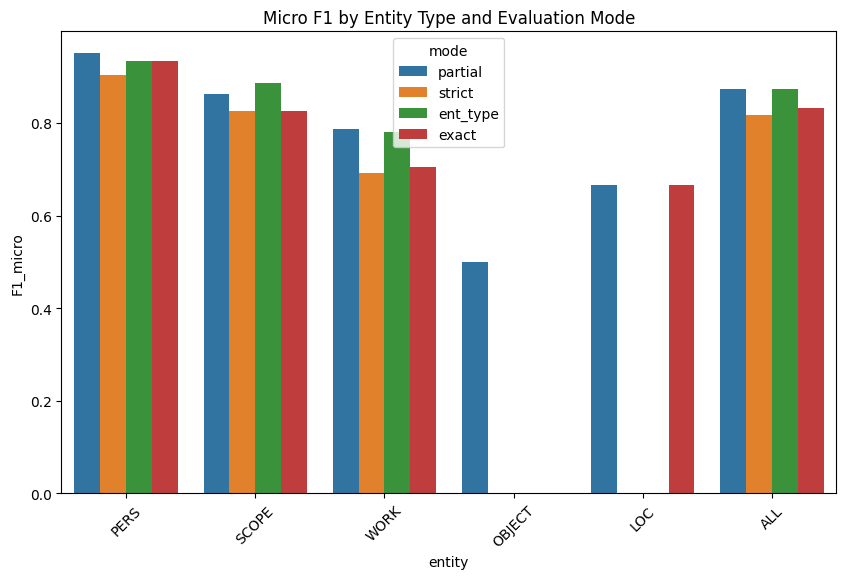

In [ ]:
#@title Bar plot: Micro F1 by entity type and evaluation mode

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(
    data=df,
    x="entity",
    y="F1_micro",
    hue="mode"
)
plt.title("Micro F1 by Entity Type and Evaluation Mode")
plt.ylabel("F1_micro")
plt.xticks(rotation=45)
plt.show()


# Bar plot: Micro F1 by entity type and evaluation mode

This chart shows how well the system performed on each entity type (PERS, SCOPE, WORK) under different evaluation modes (partial, strict, ent_type, exact).

This chart reassures audiences by demonstrating that model performance is not a vague overall measure but can be examined in detail, broken down by entity category and tested under different scoring rules. By showing that the system behaves consistently across categories such as persons, works, or thematic descriptors, the plot conveys that its reliability is measurable, transparent, and not confined to a single headline figure.

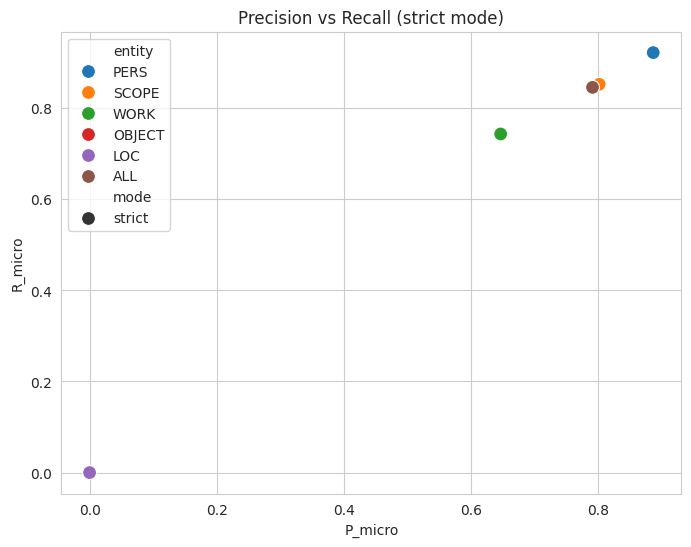

In [ ]:
#@title Scatter plot: Precision vs Recall (strict mode)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df[df["mode"]=="strict"],
    x="P_micro", y="R_micro",
    hue="entity", style="mode", s=100
)
plt.title("Precision vs Recall (strict mode)")
plt.show()


# Scatter plot: Precision vs Recall (strict mode)

This visualisation reassures audiences by highlighting the balance between accuracy (avoiding spurious annotations) and coverage (capturing as many relevant annotations as possible). Cultural Heritage professionals can see whether the model tends to over- or under-identify entities. This is critical for trust: a model that clearly shows where its boundaries lie enables practitioners to anticipate potential errors rather than encounter them unexpectedly.

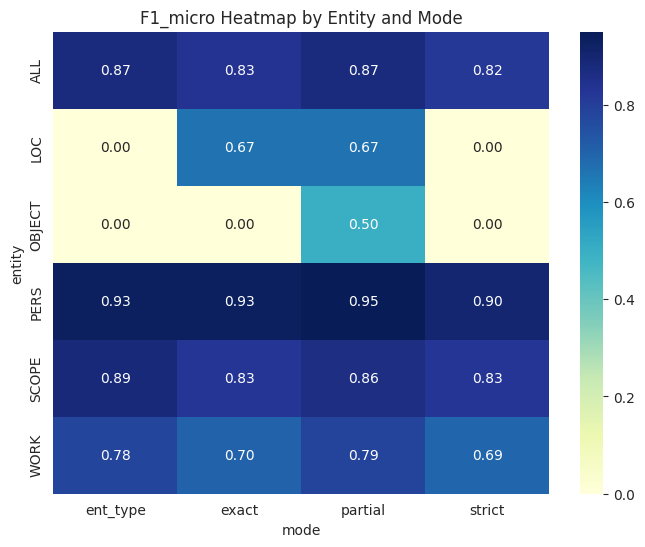

In [ ]:
#@title Heatmap: F1 scores by entity and mode

pivot = df.pivot_table(
    index="entity",
    columns="mode",
    values="F1_micro"
)

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("F1_micro Heatmap by Entity and Mode")
plt.show()


# Heatmap: F1 scores by entity and mode

The heatmap reassures audiences by providing a comparative overview of model performance at a glance. Rather than requiring interpretation of many separate statistics, it conveys consistency or variability in an intuitive, colour-coded form. This enables curators and archivists to judge whether the system is broadly dependable across different evaluation modes and categories, or whether certain areas warrant closer attention.

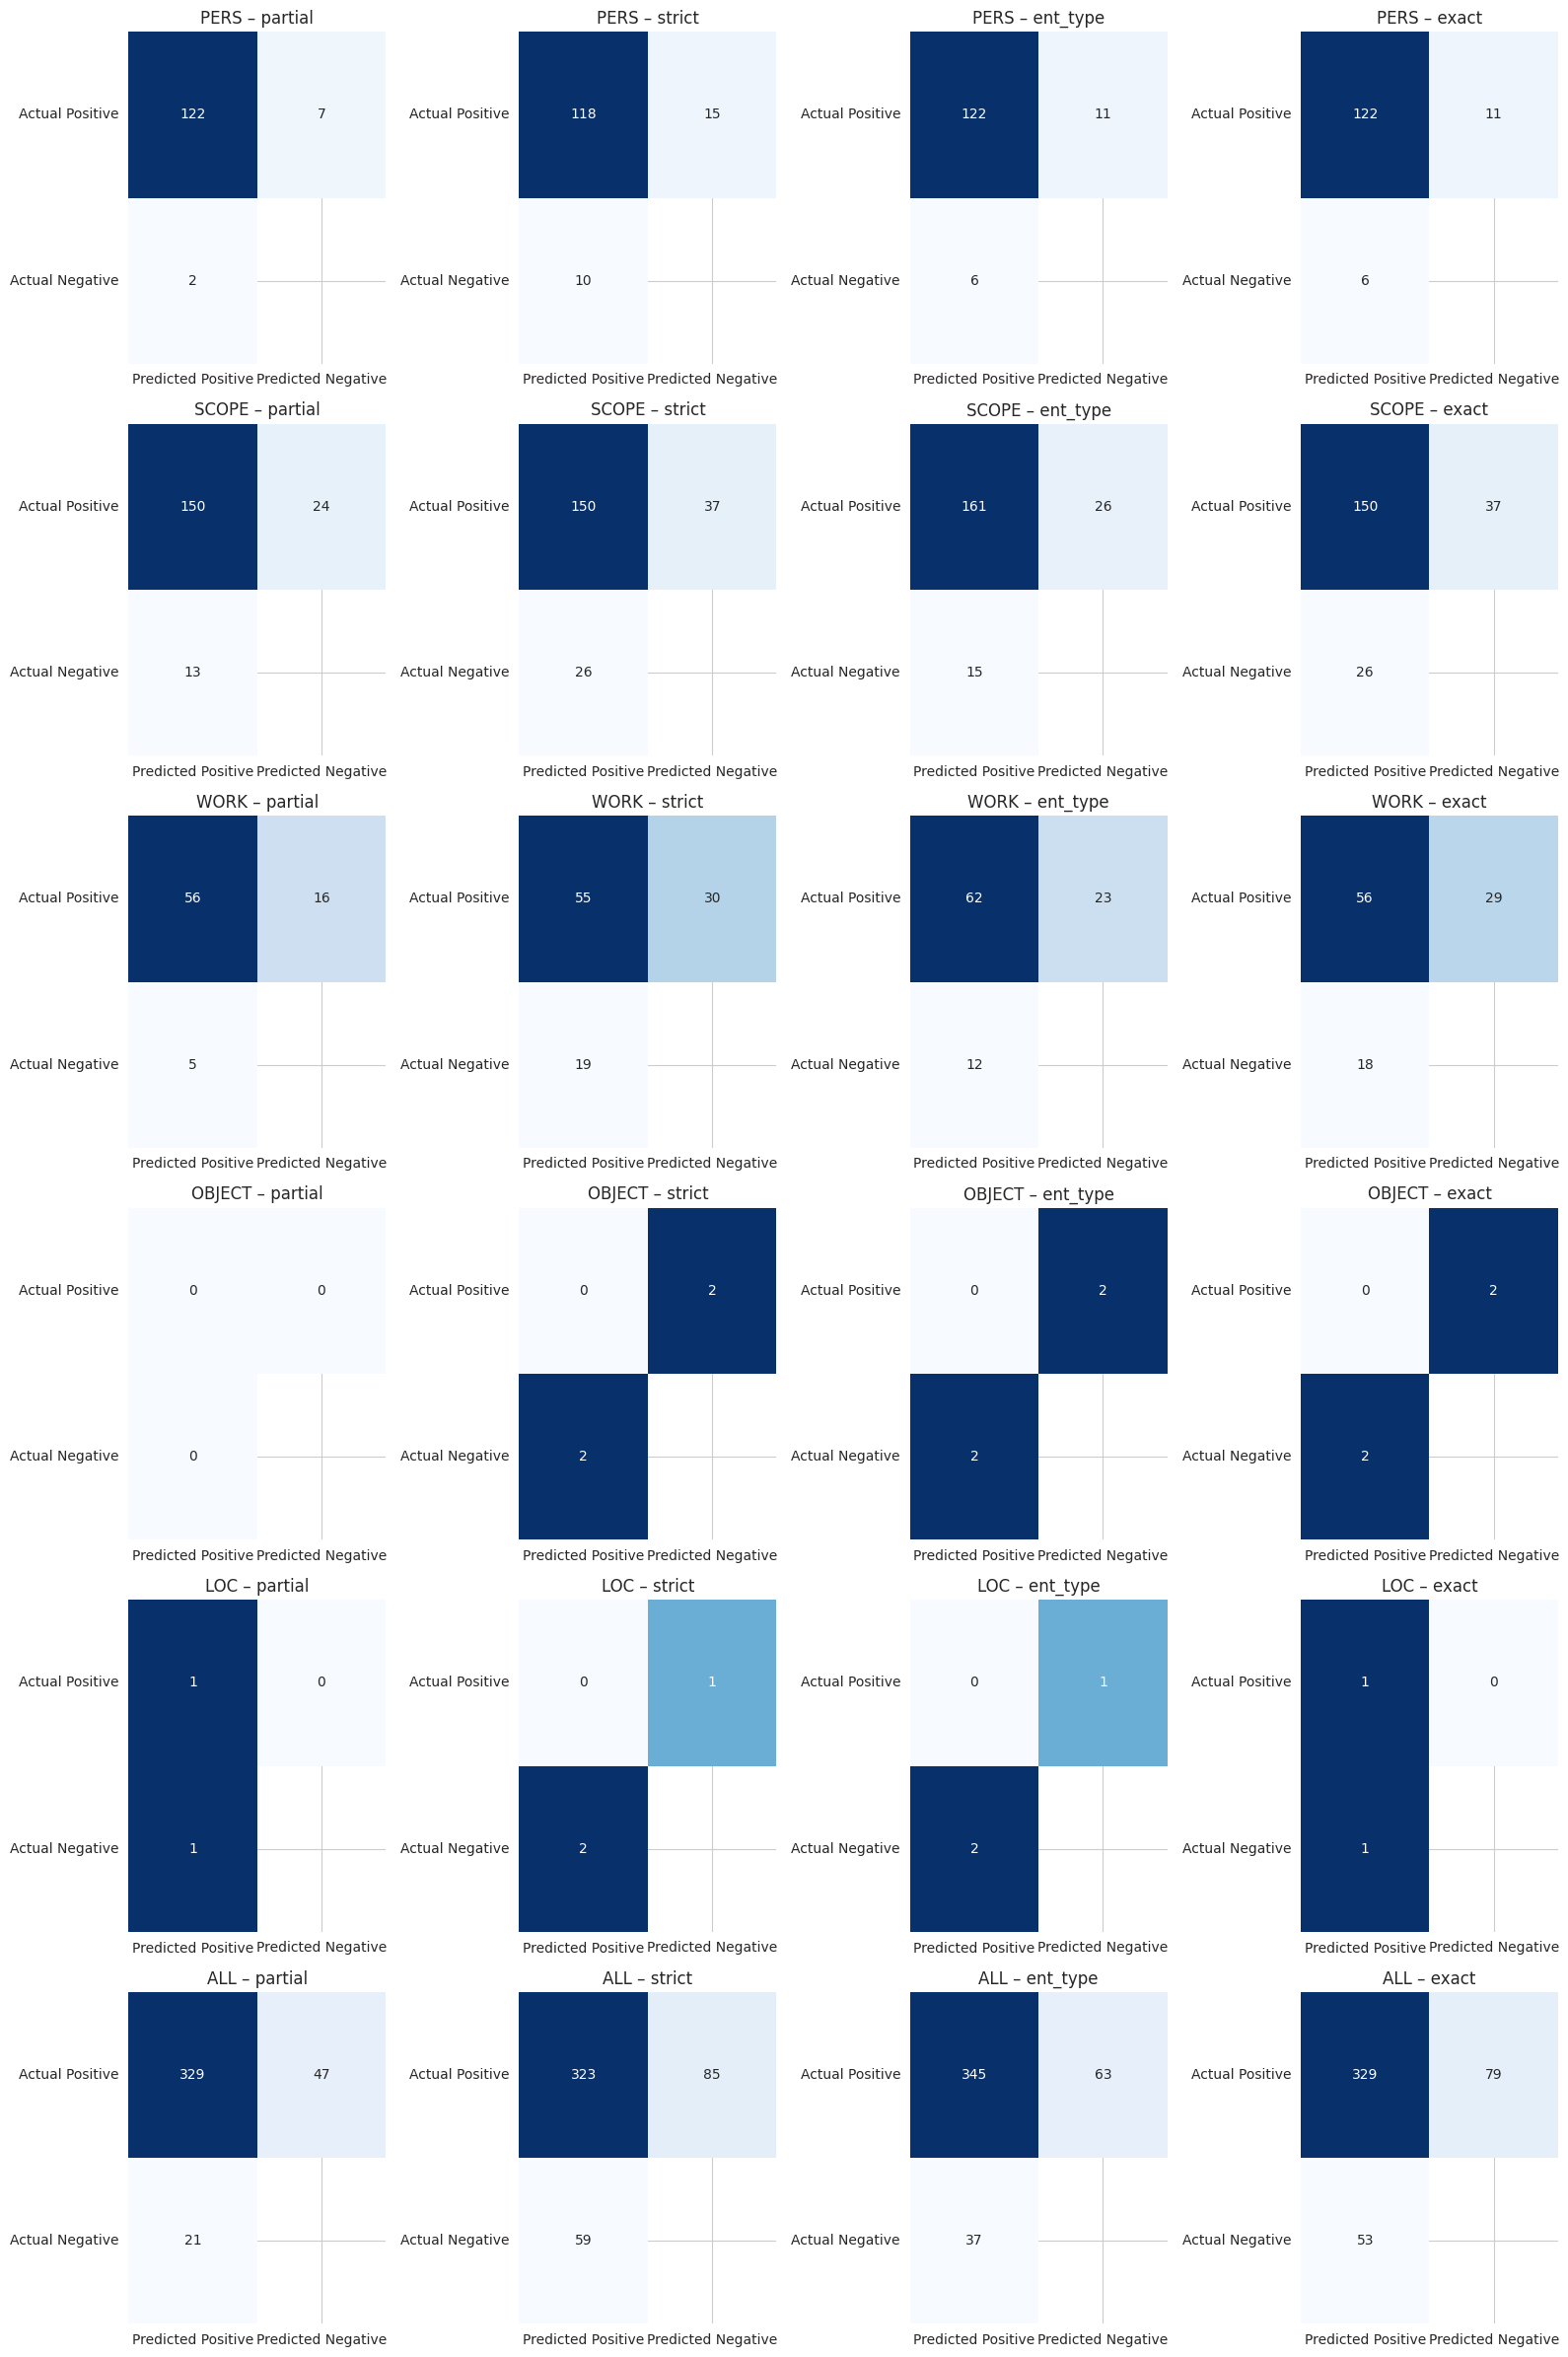

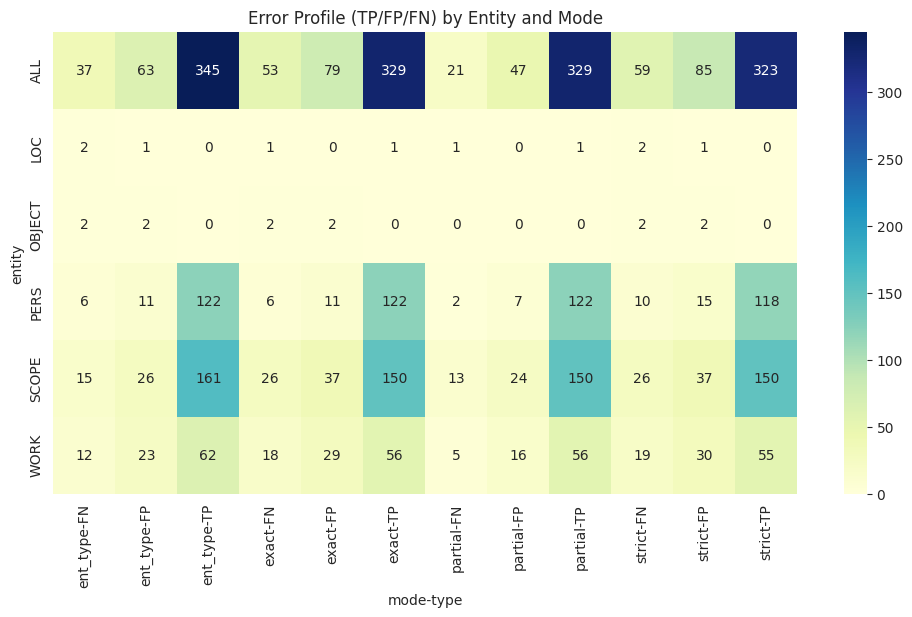

In [ ]:
#@title Generate Confusion Matrices and Heatmap

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load JSON ---
url = "https://raw.githubusercontent.com/hipe-eval/HIPE-2022-eval/main/evaluation/system-evaluations/neurbsl_bundle3_ajmc_de_1_nerc_coarse.json"
data = requests.get(url).json()

# --- 2. Flatten into tidy DataFrame ---
records = []
for level, level_data in data.items():
    for time, time_data in level_data.items():
        for led, led_data in time_data.items():
            for ent, ent_data in led_data.items():
                for mode, metrics in ent_data.items():
                    tp = metrics["correct"]
                    fp = metrics["spurious"] + metrics["incorrect"]
                    fn = metrics["missed"] + metrics["incorrect"]
                    records.append({
                        "entity": ent,
                        "mode": mode,
                        "TP": tp,
                        "FP": fp,
                        "FN": fn
                    })

df = pd.DataFrame(records)

# --- 3. Function to plot confusion matrix ---
def plot_conf_matrix(tp, fp, fn, title):
    conf_matrix = pd.DataFrame(
        [[tp, fp],
         [fn, None]],  # TN not meaningful here
        index=["Actual Positive", "Actual Negative"],
        columns=["Predicted Positive", "Predicted Negative"]
    )
    sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues", cbar=False)
    plt.title(title)
    plt.yticks(rotation=0)

# --- 4. Grid of confusion matrices (one per entity & mode) ---
entities = df["entity"].unique()
modes = df["mode"].unique()

fig, axes = plt.subplots(len(entities), len(modes), figsize=(4*len(modes), 4*len(entities)))

for i, ent in enumerate(entities):
    for j, mode in enumerate(modes):
        subset = df[(df["entity"] == ent) & (df["mode"] == mode)]
        if subset.empty:
            continue
        tp, fp, fn = subset.iloc[0][["TP", "FP", "FN"]]
        plt.sca(axes[i, j])
        plot_conf_matrix(tp, fp, fn, f"{ent} – {mode}")

plt.tight_layout()
plt.show()

# --- 5. Comparative heatmap of error counts ---
heatmap_data = df.melt(id_vars=["entity", "mode"], value_vars=["TP", "FP", "FN"],
                       var_name="type", value_name="count")

pivot = heatmap_data.pivot_table(index="entity", columns=["mode","type"], values="count")

plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=True, fmt="g", cmap="YlGnBu")
plt.title("Error Profile (TP/FP/FN) by Entity and Mode")
plt.show()


In [ ]:
#@title Sankey Diagram of NER Evaluation
import plotly.graph_objects as go

# --- 1. Prepare Sankey nodes and labels ---
# We'll show flows: entity -> mode -> outcome type
entities = df['entity'].unique().tolist()
modes = df['mode'].unique().tolist()
outcomes = ['TP', 'FP', 'FN']

labels = entities + modes + outcomes  # node labels
label_index = {label: i for i, label in enumerate(labels)}

# --- 2. Build source, target, value lists ---
sources = []
targets = []
values = []

for _, row in df.iterrows():
    # Entity -> Mode
    sources.append(label_index[row['entity']])
    targets.append(label_index[row['mode']])
    values.append(row['TP'] + row['FP'] + row['FN'])  # total annotations

    # Mode -> Outcome
    for outcome in outcomes:
        sources.append(label_index[row['mode']])
        targets.append(label_index[outcome])
        values.append(row[outcome])

# --- 3. Create Sankey diagram ---
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="skyblue"
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

fig.update_layout(title_text="NER Evaluation Sankey Diagram", font_size=12)
fig.show()


## Variations and alternatives

notes on ways in which this recipe be could be adapted or where and when alternative approaches should/could be used.